# Quick Overview

This notebook is used for classifying the type of mushrooms with CNN model or Basic CNN Architecture, for color space try using RGB for these images and using image augmentation to improve the accuracy, for the data using : 
- 900 Images for training
- 450 Images for validation or testing
- Total 1350

For labels distribution is uniform distribution.

----------------------------------------------------

This notebook has been trained Basic CNN model architecture for 300 epochs

In [1]:
import pandas as pd
import numpy as np
import cv2
import os

import tensorflow as tf
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from plotting import show_distribution
from plot_val import calc_roc_curve, plot_roc_curve, plot_confusion_matrix

from apply_processing import apply, resize_images, function_rgb, function_gray
from apply_processing import function_label, blur_images, adjust_contrast_images, rotated_labels
from apply_processing import filter_images, edge_images, contour_images, rotate_images, kmeans_images

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"Nums GPUs available : {len(physical_devices)}")

tf.config.experimental.set_memory_growth(physical_devices[0], True)

Nums GPUs available : 1


In [3]:
df = pd.read_csv("Dataset\\images_mushrooms.csv")

df.head()

,Image,Label
0,Dataset\Mushrooms\Agaricus\009_mrv34Sn4WiQ.jpg,Agaricus
1,Dataset\Mushrooms\Agaricus\010_Rk1D3EG856g.jpg,Agaricus
2,Dataset\Mushrooms\Agaricus\017_QHGfbEiWvq8.jpg,Agaricus
3,Dataset\Mushrooms\Agaricus\020_vZJfrjIwmqU.jpg,Agaricus
4,Dataset\Mushrooms\Agaricus\030_-i6kYqDvBQo.jpg,Agaricus


In [4]:
df_test = pd.read_csv("Dataset\\test_images_mushrooms.csv")

df_test.head()

,Image,Label
0,Dataset\Test Mushrooms\Agaricus\006_1_E6AXBJqn...,Agaricus
1,Dataset\Test Mushrooms\Agaricus\043_UPu2ng0N0z...,Agaricus
2,Dataset\Test Mushrooms\Agaricus\053_MKIISBeGQF...,Agaricus
3,Dataset\Test Mushrooms\Agaricus\055_Cggc3hvlPf...,Agaricus
4,Dataset\Test Mushrooms\Agaricus\065_ca8G5lwf7C...,Agaricus


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   900 non-null    object
 1   Label   900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   450 non-null    object
 1   Label   450 non-null    object
dtypes: object(2)
memory usage: 7.2+ KB


In [7]:
df['Label'].value_counts() / df.shape[0]

Cortinarius    0.111111
Hygrocybe      0.111111
Lactarius      0.111111
Boletus        0.111111
Entoloma       0.111111
Russula        0.111111
Suillus        0.111111
Agaricus       0.111111
Amanita        0.111111
Name: Label, dtype: float64

In [8]:
df_test['Label'].value_counts() / df_test.shape[0]

Cortinarius    0.111111
Hygrocybe      0.111111
Lactarius      0.111111
Suillus        0.111111
Boletus        0.111111
Entoloma       0.111111
Agaricus       0.111111
Russula        0.111111
Amanita        0.111111
Name: Label, dtype: float64

# Processing the images

In [9]:
# With Contour + Fixed contrast, brightness, sharpness

def processing_contour(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.5
    brightness = -10
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
    images_rgb = blur_images(images_rgb)
    
    images_gray = function_gray(images)
    images_gray = resize_images(images_gray, size)
    images_gray = filter_images(images_gray)
    images_gray = adjust_contrast_images(images_gray, contrast=contrast, brightness=brightness)
    images_gray = blur_images(images_gray)
    
    edged_images = edge_images(images_gray)
    
    images_contour = contour_images(edged_images, images_rgb)
    
    return list(images_contour)

In [10]:
# Random contras

def processing_random_contrast(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = np.random.randint(1, 5)
    brightness = -10
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
    images_rgb = blur_images(images_rgb)
    
    return list(images_rgb)

In [11]:
# Random Brightness

def processing_random_brightness(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.5
    brightness = np.random.randint(-100, 100)
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
#     images_rgb = blur_images(images_rgb)
    
    return list(images_rgb)

In [12]:
# Fixed contrast, brightness, sharpness

def processing_fixed(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.5
    brightness = -10
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
    images_rgb = blur_images(images_rgb)
    
    return list(images_rgb)

In [13]:
# Random sharpness

def processing_random_sharpness(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.5
    brightness = -10
    ddepth = np.random.randint(-100, 100)
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb, ddepth=ddepth)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
#     images_rgb = blur_images(images_rgb)
    
    return list(images_rgb)

In [14]:
# Random contrast, brightness
def processing_random_cb(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = np.random.randint(1, 5)
    brightness = np.random.randint(-100, 100)
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
    images_rgb = blur_images(images_rgb)
    
    return list(images_rgb)

In [15]:
# Rotated and flipped images

def processing_rotated(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.5
    brightness = -10
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
    images_rgb = blur_images(images_rgb)
    images_rgb = rotate_images(images_rgb)
    
    return list(images_rgb)

In [16]:
# Add k-means

def processing_kmeans(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.5
    brightness = -10
    
    images_rgb = function_rgb(images)
    images_rgb = resize_images(images_rgb, size)
    images_rgb = filter_images(images_rgb)
    images_rgb = adjust_contrast_images(images_rgb, contrast=contrast, brightness=brightness)
    images_rgb = kmeans_images(images_rgb, K=16)
    images_rgb = blur_images(images_rgb)

    return list(images_rgb)

In [17]:
functions = [processing_kmeans]
labels_functions = [function_label]

train_images, train_labels = apply(functions, labels_functions, df)
test_images, test_labels = apply(functions, labels_functions, df_test)

In [18]:
le = LabelEncoder()
le.fit(train_labels)

LabelEncoder()

In [19]:
train_images = np.array(train_images)
train_labels = le.transform(train_labels)

test_images = np.array(test_images)
test_labels = le.transform(test_labels)

In [20]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
train_generator = train_datagen.flow(
        train_images,
        train_labels,
        batch_size=32)

In [22]:
validation_generator = test_datagen.flow(
                        test_images,
                        test_labels,
                        batch_size=8)

# Modelling

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        18464     
Total params: 95,840
Trainable params: 95,840
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(9))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               6

In [27]:
adam_callback = tf.keras.callbacks.TensorBoard(log_dir='CNN_board/adam', histogram_freq=1)
sgd_callback = tf.keras.callbacks.TensorBoard(log_dir='CNN_board/sgd', histogram_freq=1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
save_path = 'save_model/RGB_Aug/cnn_rgb_aug.ckpt'
filename = 'save_model/RGB_Aug/cnn_rgb_aug.ckpt.index'

if os.path.isfile(filename):
    model.load_weights(save_path)
else:
    print("There's no checkpoint yet")

cp_callback = tf.keras.callbacks.ModelCheckpoint(save_path, save_weights_only=True, save_best_only=True)

In [38]:
# Open this kernel only for training the model

model_trained = model.fit(train_generator, epochs=100,  
                          validation_data=validation_generator, callbacks=[cp_callback])

Epoch 1/100
29/29 [==============================] - 16s 559ms/step - loss: 1.5572 - accuracy: 0.4456 - val_loss: 1.8748 - val_accuracy: 0.2933
Epoch 2/100
29/29 [==============================] - 17s 565ms/step - loss: 1.5635 - accuracy: 0.4389 - val_loss: 1.7478 - val_accuracy: 0.3578
Epoch 3/100
29/29 [==============================] - 16s 564ms/step - loss: 1.5604 - accuracy: 0.4322 - val_loss: 1.8015 - val_accuracy: 0.3200
Epoch 4/100
29/29 [==============================] - 16s 564ms/step - loss: 1.5736 - accuracy: 0.4211 - val_loss: 1.7719 - val_accuracy: 0.3733
Epoch 5/100
29/29 [==============================] - 16s 564ms/step - loss: 1.5395 - accuracy: 0.4456 - val_loss: 1.7779 - val_accuracy: 0.3422
Epoch 6/100
29/29 [==============================] - 16s 564ms/step - loss: 1.5332 - accuracy: 0.4644 - val_loss: 1.7333 - val_accuracy: 0.3911
Epoch 7/100
29/29 [==============================] - 16s 564ms/step - loss: 1.4790 - accuracy: 0.4511 - val_loss: 1.8179 - val_accuracy:

29/29 [==============================] - 16s 563ms/step - loss: 1.2065 - accuracy: 0.5589 - val_loss: 1.8006 - val_accuracy: 0.3844
Epoch 58/100
29/29 [==============================] - 16s 563ms/step - loss: 1.2260 - accuracy: 0.5767 - val_loss: 1.8569 - val_accuracy: 0.3578
Epoch 59/100
29/29 [==============================] - 16s 562ms/step - loss: 1.1970 - accuracy: 0.5767 - val_loss: 1.7591 - val_accuracy: 0.3889
Epoch 60/100
29/29 [==============================] - 16s 562ms/step - loss: 1.1614 - accuracy: 0.5856 - val_loss: 1.8259 - val_accuracy: 0.3756
Epoch 61/100
29/29 [==============================] - 16s 562ms/step - loss: 1.1924 - accuracy: 0.5578 - val_loss: 1.8747 - val_accuracy: 0.3800
Epoch 62/100
29/29 [==============================] - 16s 562ms/step - loss: 1.1689 - accuracy: 0.5733 - val_loss: 1.7780 - val_accuracy: 0.3867
Epoch 63/100
29/29 [==============================] - 16s 562ms/step - loss: 1.1852 - accuracy: 0.5711 - val_loss: 1.8172 - val_accuracy: 0.377

In [36]:
model.evaluate(test_images / 255.0, test_labels)

15/15 [==============================] - 3s 166ms/step - loss: 1.7793 - accuracy: 0.3533


[1.7793176174163818, 0.35333332419395447]

## Evaluation

### ROC and AUC

In [31]:
model_proba = model.predict(test_images / 255.0)

In [32]:
fprs, tprs, aucs = calc_roc_curve(test_labels, model_proba)

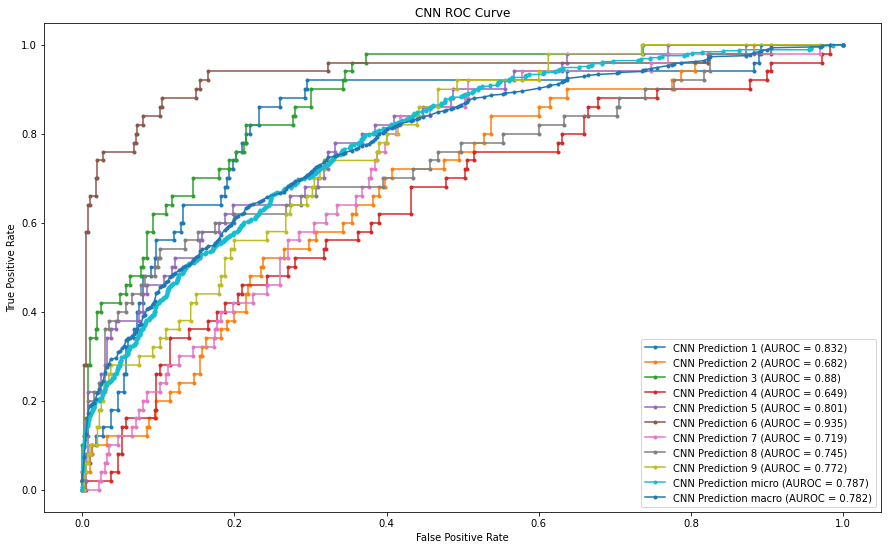

In [33]:
fig, ax = plt.subplots(figsize=(15,9))

plot_roc_curve(fprs, tprs, aucs, "CNN")

### Confusion Matrix

In [34]:
model_pred = np.argmax(model.predict(test_images / 255.0), axis=1)

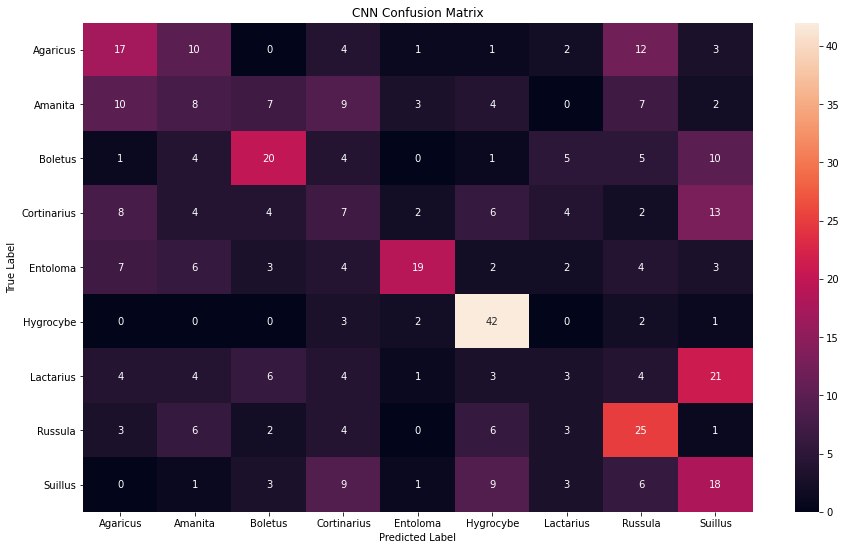

In [35]:
fig, ax = plt.subplots(figsize=(15, 9))

plot_confusion_matrix(le.inverse_transform(test_labels), test_labels, model_pred, 'CNN')